# Kernel Regression

In [7]:
CrossValCalcIt = true       #true: do cross validation calculations, otherwise not

true

In [2]:
using PyPlot

include("jlFiles/printmat.jl")
include("jlFiles/excise.jl")
include("jlFiles/lagnPs.jl")
include("jlFiles/OlsFn.jl")

INFO: Precompiling module PyPlot.


OlsFn (generic function with 1 method)

In [3]:
xx  = readdlm("Data/FFdSizePs.csv",',',header=true)
xx  = xx[1]
ymd = xx[:,1]             #[YearMonthDay]
R   = xx[:,11]            #returns for the size portfolio we want to study

xx  = excise([R lagnPs(R)])             #return and lagged return: dependent variable and regressor
y   = xx[:,1]
x   = xx[:,2]
T   = size(x,1)
xx = nothing

println("Sample size: $T")

Sample size: 8324



A kernel regression is of the form
$$
\hat{b}(x)=\frac{\sum\nolimits_{t=1}^{T}w_{t}(x)y_{t}}{\sum\nolimits_{t=1}^{T}w_{t}(x)},
$$
where $w_{t}(x)$ is the weight of observation $t$, defined by a kernel function.

The function KernRegNormalFn uses a normal kernel, $N(x,h^{2})$.

In [4]:
function KernRegNormalFn(y,x,xGrid,h,vv)

  Ngrid = length(xGrid)                  #number of grid points

  bHat = fill(NaN,Ngrid)                 #y(t) = b[x(t)] + e(t)

  for i = 1:Ngrid                        #loop over elements in xGrid
    zi      = (x - xGrid[i])/h
    w       = exp.(-zi.^2/2)./(h*sqrt(2*pi))       #gaussian kernel, with "std" = h
    bHat[i] = sum(w[vv].*y[vv])/sum(w[vv])        #sum over observations (data)
  end

  return bHat

end

KernRegNormalFn (generic function with 1 method)

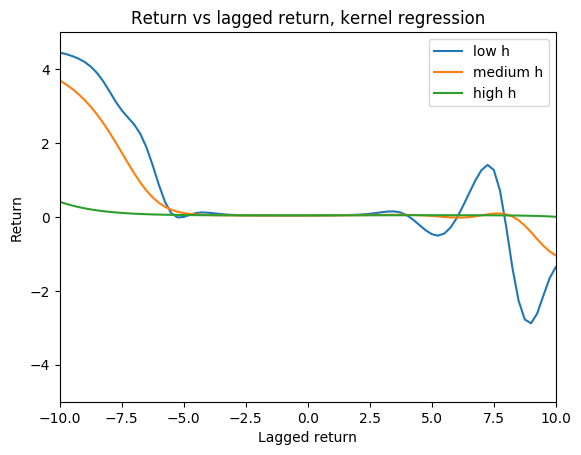

In [5]:
xGrid = collect(-10:0.25:10)
h     = 1.5
bHat    = KernRegNormalFn(y,x,xGrid,h,1:T)         #baseline choice of h
bHatHih = KernRegNormalFn(y,x,xGrid,h*2,1:T)       #high h
bHatLoh = KernRegNormalFn(y,x,xGrid,h*0.5,1:T)     #low h

figure()
ha = plot(xGrid,bHatLoh,xGrid,bHat,xGrid,bHatHih)
  xlim(minimum(xGrid),maximum(xGrid))
  ylim(-5,5)
  title("Return vs lagged return, kernel regression")
  xlabel("Lagged return")
  ylabel("Return")
legend(["low h";"medium h";"high h"])
show()

## Rule of Thumb Choice of h

Run the regression 

$
y=\alpha+\beta x+\gamma x^{2}+\varepsilon
$

and use the following rule-of-thumb choice

$
h  =T^{-1/5}|\gamma|^{-2/5}\sigma_{\varepsilon}^{2/5}(x_{\max}-x_{\min})^{1/5}\times0.6.
$

In practice, replace $x_{\max}-x_{\min}$ by the difference between the 90th
and 10th percentiles of $x$.

In [6]:
(b,res,) = OlsFn(y,[x.^2 x ones(T)])             #rule of thumb bandwidth

sigma = std(res)
gamm  = b[1]
xSort = sort(x)
x_10  = xSort[floor(Int,T*0.1)]          #crude 10th and 90th percentiles
x_90  = xSort[floor(Int,T*0.9)]

h_crude = 0.6*sigma^(2/5)*abs(gamm)^(-2/5)*(x_90-x_10)^(1/5)*T^(-1/5)

printlnPs("\nRule-of-thumb value of h: ",h_crude)


Rule-of-thumb value of h:      0.667


## Cross-Validation (leave-one-out)

To do a cross-validation 

(1) Pick a bandwidth $h$, do the kernel regression
but leave out observation $t$ and then record the out-of-sample prediction error $y_{t}-\hat{b}_{-t}
(x_{t},h)$. Notice that this is the error for observation $t$ only. 

(2) Repeat for all $t=1-T$ to calculate the EPE

$
\text{EPE}(h)=\sum\nolimits_{t=1}^{T}\left[  y_{t}-\hat{b}_{-t}(x_{t},h)\right]  ^{2}/T,
$

(3) Finally, redo for several different values of $h$---and pick the one
that minimizes EPE$(h)$. 


Cross-validation calculations take some time


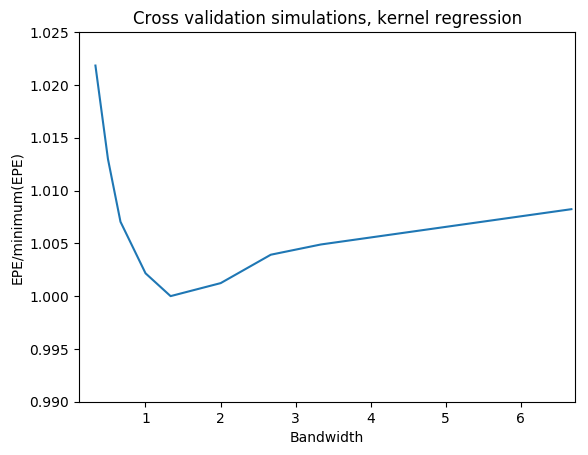

h and EPE:
     0.167       NaN
     0.334     1.314
     0.501     1.302
     0.667     1.295
     1.001     1.288
     1.335     1.286
     2.002     1.287
     2.670     1.291
     3.337     1.292
     6.674     1.296



In [8]:
if CrossValCalcIt

  println("\nCross-validation calculations take some time")

  hM = h_crude*[0.25 0.5 0.75 1 1.5 2 3 4 5 10]'

  Nh   = length(hM)
  EPEM = fill(NaN,(T,Nh))
  for t = 1:T
    v_No_t = setdiff(1:T,t)
    for j = 1:Nh
      b_t       = KernRegNormalFn(y,x,x[t],hM[j],v_No_t)   #fitted b[x(t)]
      EPEM[t,j] = (y[t] - b_t[1])^2
    end
  end
  EPE = mean(EPEM,1)'
  println("h and EPE:")
  printmat([hM EPE])

  figure()
    ha = plot(hM,EPE/minimum(EPE))
    xlim(minimum(hM)-0.05,maximum(hM)+0.05)
    ylim(0.99,1.025)
    title("Cross validation simulations, kernel regression")
    xlabel("Bandwidth")
    ylabel("EPE/minimum(EPE)")
    show()

end